In [2]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input, merge
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda
from keras.models import Sequential, Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
import pandas as pd
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn import cross_validation
# from sklearn import preprocessing
 
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from keras import losses
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn import cross_validation
# from sklearn import preprocessing
import pandas as pd
from PIL import Image
import threading
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

Using TensorFlow backend.


In [10]:

triples_train = pd.read_csv("seen-dataset/dataset_seen_training_siamese.csv")
triples_test = pd.read_csv("seen-dataset/dataset_seen_validation_siamese.csv")
# print(triples_test)
triples_test = triples_test.drop("Unnamed: 0", 1)

In [11]:
TRAINING_IMAGE_DIR = "./seen-dataset/TrainingSet/"
VALIDATION_IMAGE_DIR = "./seen-dataset/ValidationSet/"

def load_image(image_name):
    if image_name not in image_cache:
        image = cv2.imread(os.path.join(TRAINING_IMAGE_DIR,image_name),0)
        if image is None:
            image = cv2.imread(os.path.join(VALIDATION_IMAGE_DIR,image_name),0)
        image = image.reshape((64,64,1))
        image_cache[image_name] = image
    return image_cache[image_name]

def datagen(image_triples, batch_size):
    while True:
        # loop once per epoch
        indices = np.random.randint(0,len(image_triples),batch_size)
        #print(type(image_triples))
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]
            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                images_left.append(load_image(lhs))
                images_right.append(load_image(rhs))              
                labels.append(label)
            Xlhs = np.array(images_left)
            Xrhs = np.array(images_right)
            Y = np_utils.to_categorical(np.array(labels), num_classes=2)
            yield ([Xlhs, Xrhs], Y)


In [12]:
BATCH_SIZE = 64
imDim = 64
input_shape  = (imDim,imDim,1)
inp_img = Input(shape = (imDim,imDim,1), name = 'ImageInput')
model = inp_img

#     model = Input(shape=(imDim,imDim,1))
#     model.add(Input(shape = (imDim,imDim,1), name = 'FeatureNet_ImageInput'))
model = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='valid')(model)
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model = MaxPooling2D((2,2), padding='valid')(model)
model = Conv2D(64, (3, 3), activation='relu',padding='valid')(model)
#     model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model = MaxPooling2D((2,2),padding='valid')(model)
#     model.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
model = Conv2D(128, (3, 3), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)
#     model.add(Conv2D(1, (3, 3), activation='relu',padding='same'))
#     model.add(Conv2D(2, (3, 3), activation='relu',padding='same'))

model = Conv2D(256, (1, 1), activation='relu',padding='valid')(model)
model = MaxPooling2D((2,2),padding='valid')(model)

model = Conv2D(64, (1, 1), activation='relu',padding='valid')(model)
# model = MaxPooling2D((2,2),padding='valid')(model)
model = Flatten()(model)

# img_in = np.array((-1,imDim,imDim,1), dtype='float32')
# img_in = tf.placeholder(shape=(imDim,imDim,1), dtype='float32')

feat = Model(inputs=[inp_img], outputs=[model],name = 'Feat_Model')
feat.summary()


# In[27]:

left_img = Input(shape = (imDim,imDim,1), name = 'left_img')
right_img = Input(shape = (imDim,imDim,1), name = 'right_img')


# In[28]:

left_feats = feat(left_img)
right_feats = feat(right_img)


# In[35]:

from keras.layers import concatenate
import random


# In[36]:

merged_feats = concatenate([left_feats, right_feats], name = 'concat_feats')
merged_feats = Dense(1024, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(4, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(2, activation = 'sigmoid')(merged_feats)
similarity_model = Model(inputs = [left_img, right_img], outputs = [merged_feats], name = 'Similarity_Model')
# similarity_model.summary()


similarity_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

NUM_EPOCHS = 10

image_cache = {}
train_gen = datagen(triples_train.values, BATCH_SIZE)
val_gen = datagen(triples_test.values, BATCH_SIZE)

num_train_steps = (len(triples_train)//BATCH_SIZE)
num_val_steps = (len(triples_test)//BATCH_SIZE)

history = similarity_model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=NUM_EPOCHS,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
__________

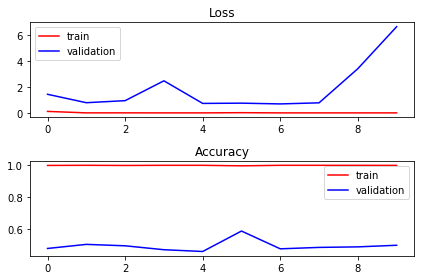

In [14]:
import matplotlib.pyplot as plt 

plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [35]:
# SVG(model_to_dot(similarity_model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))
plot_model(similarity_model, to_file='model.png', show_layer_names=True, show_shapes=True)